Pandas recently contucted a user survey to help guide future development.
Thanks to everyone who participated! This post presents the high-level results.

This analysis and the raw data can be found [on GitHub](https://github.com/pandas-dev/pandas-user-surveys) and run on Binder

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pandas-dev/pandas-user-surveys/master?filepath=2019.ipynb)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.dpi'] = 150

df = pd.read_csv("data/2019.csv.gz", parse_dates=['Timestamp'])

We had about 1250 repsonses over the 15 days we ran the survey in the summer of 2019.

# About the Respondents

There was a fair amount of representation across pandas experience and frequeny of use, though the majority of respondents are on the more experienced side.

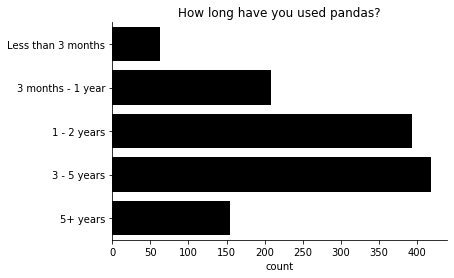

In [2]:
order = [
    'Less than 3 months',
    '3 months - 1 year',
    '1 - 2 years',
    '3 - 5 years',
    '5+ years',
]

sns.countplot(y='How long have you used pandas?',
              data=df, order=order,
              color='k').set(title="How long have you used pandas?",
                             ylabel="");
sns.despine()

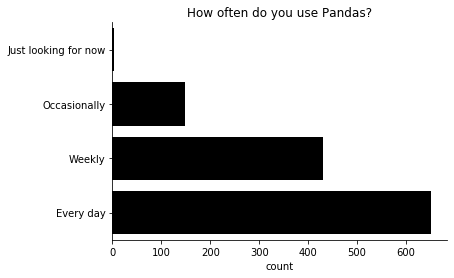

In [3]:
order = [
    "Just looking for now",
    "Occasionally",
    "Weekly",
    "Every day"
]

sns.countplot(y='How often do you use Pandas?', data=df, order=order,
              color='k').set(title="How often do you use Pandas?",
                             ylabel="");
sns.despine()

We included a few questions that were also asked in the [Python Developers Survey](https://www.jetbrains.com/research/python-developers-survey-2018/) so we could compare Pandas' population to Python's. 

90% of our respondents use Python as a primary language (compared with 84% from the PSF survey).

In [4]:
pct_format = "{:0.2%}".format

df['Is Python your main language?'].str.replace("No.*", "No").value_counts(normalize=True).apply(pct_format)

Yes    90.67%
No      9.33%
Name: Is Python your main language?, dtype: object

Windows users are well represented (see [Steve Dower's talk](https://www.youtube.com/watch?v=uoI57uMdDD4) on this topic).

In [5]:
oses = [
    "Linux",
    "Windows",
    "MacOS"
]
df['What Operating Systems do you use?'].str.split(';').explode().value_counts().div(len(df)).loc[oses].apply(pct_format)

Linux      61.57%
Windows    60.21%
MacOS      42.75%
Name: What Operating Systems do you use?, dtype: object

For environment isolation, [conda](https://conda.io/en/latest/) was the most popular.

In [6]:
def split_and_explode(s):
    return s.str.split(";").explode().to_frame()

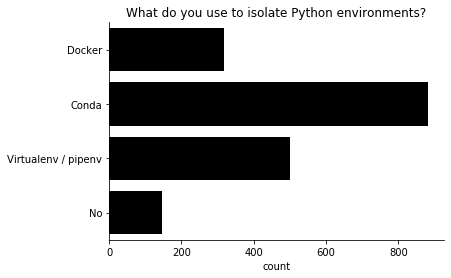

In [7]:
replace = {
    "No, I don't isolate environments": "No"
}

col = 'Do you use any of the following tools to isolate Python environments, if any? (multiple answers)'

sns.countplot(y=col,
              data=split_and_explode(df[col]).replace(replace),
              color='k').set(title='What do you use to isolate Python environments?',
                             ylabel="");
sns.despine()

Most repondents are Python 3 only.

In [8]:
df['Python 2 or 3?'].value_counts(normalize=True).rename(index={"2;3": "2 & 3"}).apply(pct_format)

3        92.39%
2 & 3     6.80%
2         0.81%
Name: Python 2 or 3?, dtype: object

## Pandas APIs

It can be hard for open source projects to know what features are actually used. We asked a few questions to get an idea.

CSV and Excel are (for better or worse) the most popular formats.

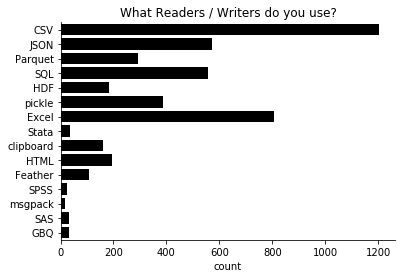

In [9]:
sns.countplot(y='What readers / writers do you use?',
              data=df['What readers / writers do you use?'].str.split(';').explode().to_frame(),
              color='k').set(title="What Readers / Writers do you use?",
                             ylabel="")
sns.despine();

In preperation for a possible refactor of pandas internals, we wanted to get a sense for
how common wide (100s of columns or more) DataFrames are.

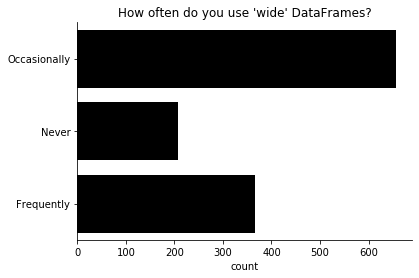

In [10]:
sns.countplot(y='How often do you work with "wide" DataFrames (100s of columns or more)',
              data=df, color='k').set(title="How often do you use 'wide' DataFrames?",
                                      ylabel="");
sns.despine()

Pandas is slowly growing new exentension types. Categoricals are the most popular,
and the nullable integer type is already almost as popular as datetime with timezone.

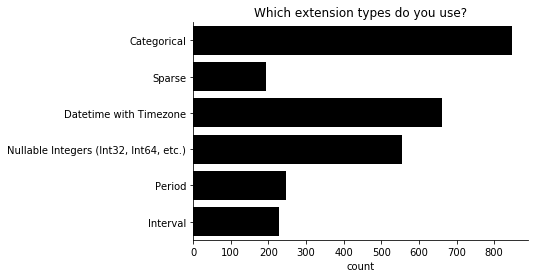

In [11]:
sns.countplot(y='Which extension types do you use?',
              data=split_and_explode(df['Which extension types do you use?']),
              color='k').set(title="Which extension types do you use?",
                             ylabel="")
sns.despine();

More and better examples seem to be a high-priority development item.
Pandas recently received a NumFOCUS grant to improve our documentation,
which we're using to write tutorial-style documentation, which should help
meet this need.

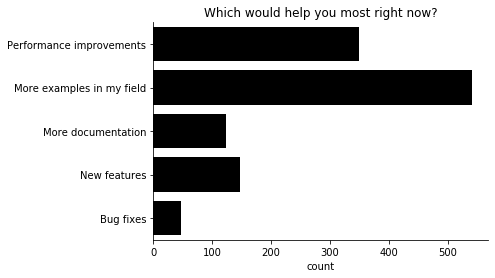

In [12]:
sns.countplot(y='Which would help you most right now?',
              data=df,
              color='k').set(title="Which would help you most right now?",
                             ylabel="")
sns.despine()

We also asked about specific, commonly-requested features.

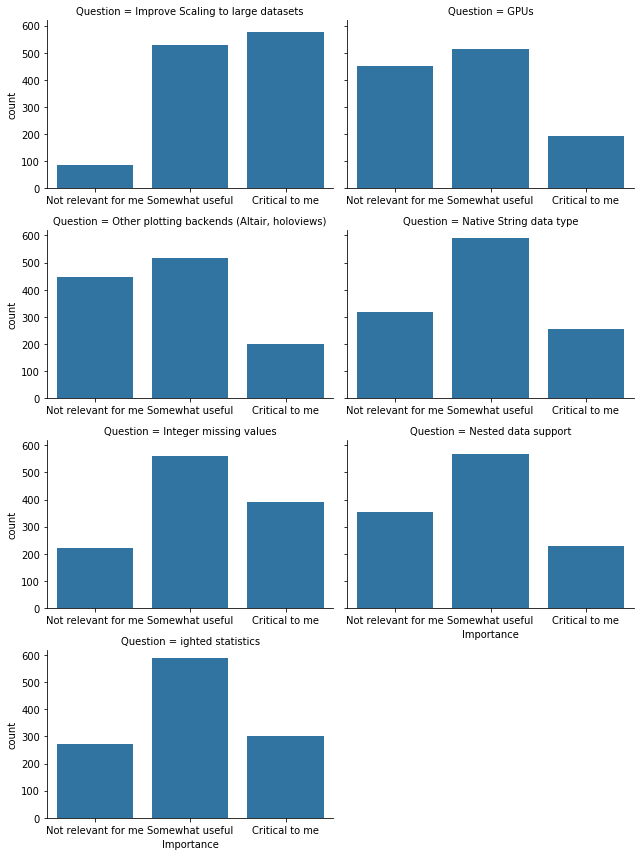

In [13]:
common = (df[df.columns[df.columns.str.startswith("What common feature")]]
          .rename(columns=lambda x: x.lstrip("What common feature requests do you care about most?[").rstrip(r"]")))

counts = (
    common.apply(pd.value_counts)
    .T.stack().reset_index()
    .rename(columns={'level_0': 'Question', 'level_1': "Importance", 0: "count"})
)

order = ["Not relevant for me", "Somewhat useful", 'Critical to me']
g = (
    sns.FacetGrid(counts, col="Question", col_wrap=2, aspect=1.5, sharex=False, height=3)
    .map(sns.barplot, "Importance", "count", order=order)
)

Of these, the clear standout is "scaling" to large datasets. A couple observations:

1. Perhaps pandas' documentation should do a better job of promoting libraries that provide scalable dataframes (like [Dask](https://dask.org), [vaex](https://dask.org), and [modin](https://modin.readthedocs.io/en/latest/))
2. Memory efficiency (perhaps from a native string data type, fewer internal copies, etc.) is a valuable goal.

After that, the next-most critical improvement is integer missing values. Those were actually added in [Pandas 0.24](https://pandas.pydata.org/pandas-docs/stable/whatsnew/v0.24.0.html#optional-integer-na-support), but they're not the default, and there's still some incompatibilites with the rest of pandas API.

Pandas is a less conservative library than, say, NumPy. We're approaching 1.0, but on the way we've made many deprecations and some outright API breaking changes. Fortunately, most people are OK with the tradeoff.

In [14]:
df['Is Pandas stable enough for you?'].value_counts(normalize=True).apply(pct_format)

Yes    94.89%
No      5.11%
Name: Is Pandas stable enough for you?, dtype: object

There's a perception (which is shared by many of the pandas maintainers) that the pandas API is too large. To measure that, we asked whether users thought that pandas' API was too large, too small, or just right.

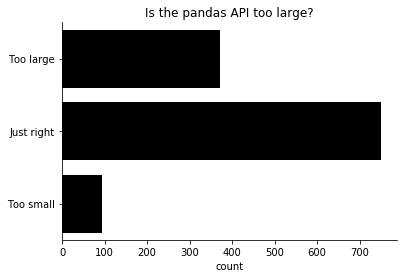

In [15]:
renamer = {"Generally speaking, do you think pandas' API is too large (hard to remember / find the method you want) or too small (you wish it had more features)?": "Is the pandas API too large?"}
sns.countplot(y="Is the pandas API too large?",
              data=df.rename(columns=renamer),
              color='k').set(title="Is the pandas API too large?",
                             ylabel="")
sns.despine();

Finally, we asked for an overall satisfaction with the library, from 1 (not very unsatisfied) to 5 (very satisfied).

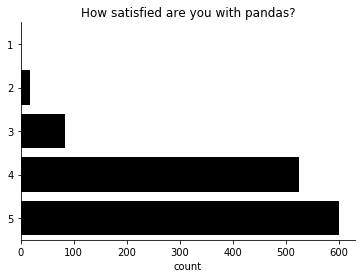

In [16]:
sns.countplot(y='How satisfied are you with pandas?',
              data=df[['How satisfied are you with pandas?']].dropna().astype(int),
              color='k').set(title="How satisfied are you with pandas?",
                             ylabel="")
sns.despine();

Most people are very satisfied. The average response is 4.39. I look forward to tracking this number over time.

If you're analyzing the raw data, be sure to share the results with us [@pandas_dev](https://twitter.com/pandas_dev).